## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import json
import ast
from sklearn.preprocessing import StandardScaler
from google.colab.patches import cv2_imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd drive/MyDrive/smai

/content/drive/MyDrive/smai


## Load and display the data

In [4]:
#your code here
data = pd.read_csv('Tweets.csv')
labels = pd.read_csv('ground_truth.csv')
print(data.shape)
print(labels.shape)
data.head(4)

(11099, 21)
(11099, 1)


,created_at,id,id_str,text,truncated,entities,metadata,source,is_quote_status,retweet_count,...,lang,user_name,user_screen_name,user_followers_count,user_friends_count,user_listed_count,user_created_at,user_favourites_count,user_verified,user_statuses_count
0,Tue Jul 31 13:34:34 +0000 2018,1.024290e+18,1.024290e+18,RT @EdwardTHardy: The 7th US Circuit Court of ...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",False,113,...,en,Sherry Wahl,queenfancygirl,153,264,7,Thu Mar 18 19:16:31 +0000 2010,32984,False,31308
1,Tue Jul 31 13:34:14 +0000 2018,1.024290e+18,1.024290e+18,RT @VenomMovie: The world has enough superhero...,False,"{'hashtags': [{'text': 'Venom', 'indices': [64...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",False,5902,...,en,Kay Khairil ðŸŒ,ikaykhairil,780,382,12,Wed Mar 17 03:27:51 +0000 2010,6648,False,87272
2,Tue Jul 31 13:34:40 +0000 2018,1.024290e+18,1.024290e+18,RT @FutbolBible: Teachers vs Students match &a...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",False,3745,...,en,Charlie Hamilton,ch100897,255,246,1,Sun Mar 03 09:23:03 +0000 2013,5426,False,1731
3,Tue Jul 31 13:34:27 +0000 2018,1.024290e+18,1.024290e+18,RT @mashable: Someone from 'The Office' actual...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com"" rel=""nofollow"">Tw...",False,10,...,en,Mike Santos,mikesantosx71,2419,2428,4,Thu May 25 14:37:29 +0000 2017,5993,False,2153


In [5]:
print(type(data))
data.head()
data.shape

labels.shape
labels.head(3)

<class 'pandas.core.frame.DataFrame'>


,popularity
0,0
1,0
2,1


## Exploratory Data Analysis
*This is an ungraded section but is recommended to get a good grasp on the dataset*

In [6]:
# your code here
data.entities[1]


"{'hashtags': [{'text': 'Venom', 'indices': [64, 70]}], 'symbols': [], 'user_mentions': [{'screen_name': 'VenomMovie', 'name': 'Venom Movie', 'id': 865635702121185280, 'id_str': '865635702121185280', 'indices': [3, 14]}], 'urls': [], 'media': [{'id': 1024268216636329984, 'id_str': '1024268216636329984', 'indices': [92, 115], 'media_url': 'http://pbs.twimg.com/media/DjbweZ5U0AAbdOj.jpg', 'media_url_https': 'https://pbs.twimg.com/media/DjbweZ5U0AAbdOj.jpg', 'url': 'https://t.co/dnh8nqwkfJ', 'display_url': 'pic.twitter.com/dnh8nqwkfJ', 'expanded_url': 'https://twitter.com/VenomMovie/status/1024278510771134464/video/1', 'type': 'photo', 'sizes': {'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 680, 'h': 680, 'resize': 'fit'}, 'medium': {'w': 720, 'h': 720, 'resize': 'fit'}, 'large': {'w': 720, 'h': 720, 'resize': 'fit'}}, 'source_status_id': 1024278510771134464, 'source_status_id_str': '1024278510771134464', 'source_user_id': 865635702121185280, 'source_user_id_str': '86563

In [7]:
hash_tag=[]
ent=data.entities
#print(ent)
for rows in ent:
    res = ast.literal_eval(rows)    #coverting to dictionary
    if res['hashtags']:
        hash_tag.append(1)
    else:
        hash_tag.append(0)
        
data["media_img"] = data.apply(lambda data: data["entities"].count(".jpg"),axis=1)
#data["media_img"]
data["media_vid"] = data.apply(lambda data: data["entities"].count("video"),axis=1)
#data["media_vid"]
data["links_count"] = data.apply(lambda data: data["text"].count("http"),axis=1)
data["links_count"]



0        0
1        1
2        1
3        2
4        0
        ..
11094    0
11095    0
11096    1
11097    0
11098    1
Name: links_count, Length: 11099, dtype: int64

## Part-1
*Vectorize tweets using only meta data*

In [8]:
def get_features(data):
  n_data=data.drop(columns=['created_at', 'id', 'id_str','text',
 'truncated','entities',
 'metadata','source','favorite_count',
 'is_quote_status','lang','user_name','user_screen_name',
 'user_listed_count','user_created_at','user_verified','user_statuses_count'])

  n_data['hashtags']=hash_tag
  n_data['links_count']=data['links_count']
  n_data.head(3)
  list(n_data.columns)
  features=n_data
  
  return features
 

In [9]:
features=get_features(data)
features

,retweet_count,user_followers_count,user_friends_count,user_favourites_count,media_img,media_vid,links_count,hashtags
0,113,153,264,32984,0,0,0,0
1,5902,780,382,6648,2,1,1,1
2,3745,255,246,5426,2,3,1,0
3,10,2419,2428,5993,0,0,2,0
4,25306,314,722,6285,0,0,0,0
...,...,...,...,...,...,...,...,...
11094,5,802,1353,79149,0,0,0,1
11095,8393,429,599,2029,0,0,0,0
11096,0,135,94,90,0,0,1,0
11097,18,505,243,15829,0,0,0,0


In [10]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features

features.values[:] = StandardScaler().fit_transform(features)


In [ ]:
features.head(5)

,retweet_count,user_followers_count,user_friends_count,user_favourites_count,media_img,media_vid,links_count,hashtags
0,0,0,0,0,0,0,0,0
1,0,0,0,0,2,1,1,2
2,0,0,0,0,2,5,1,0
3,0,0,0,0,0,0,3,0
4,1,0,0,0,0,0,0,0


In [11]:
from sklearn.model_selection import train_test_split
def data_split(features, labels):
  X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
  print(X_train.shape)
  print(X_test.shape)
  print(y_train.shape)
  print(y_test.shape)

  print(type(X_train))
  print(type(X_test))
  print(type(y_train))
  print(type(y_test))
  return X_train, X_test, y_train, y_test

In [12]:
X_train, X_test, y_train, y_test=data_split(features, labels)

(8879, 8)
(2220, 8)
(8879, 1)
(2220, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


Perform KNN using the vector obtained from get_features() function. Following are the steps to be followed:
1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values. 

 # **Classifier for Metadata**

In [28]:
# your code here
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

def nearest_nbrs(X_train,X_test, y_train,y_test):
  accuracies = []
  for i in range(1, 50, 2):
    nbrs = NearestNeighbors(n_neighbors=i, algorithm='ball_tree')
    nbrs.fit(X_train)
    distances, indices = nbrs.kneighbors(X_test)
    y_pred = y_train.values[indices]
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    #classifier
    prediction=stats.mode(y_pred, axis = 1).mode
    prediction=np.array(prediction)
    score = len(prediction[prediction==np.array(y_test)]) / y_test.shape[0]
    
    accuracies.append(score)


  print(accuracies)

  #plot
  plt.style.use('ggplot')
  plt.figure(figsize=(12,10))
  plt.scatter(range(1, 50, 2), accuracies)
  plt.title("The Prediction accuracies")
  plt.xlabel("Number of Neighbors")
  plt.ylabel("Accuracy")
  plt.show()

[0.9441441441441442, 0.9454954954954955, 0.9472972972972973, 0.9472972972972973, 0.9472972972972973, 0.9436936936936937, 0.9472972972972973, 0.9472972972972973, 0.9472972972972973, 0.9472972972972973, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9468468468468468, 0.9459459459459459, 0.9459459459459459, 0.9459459459459459]


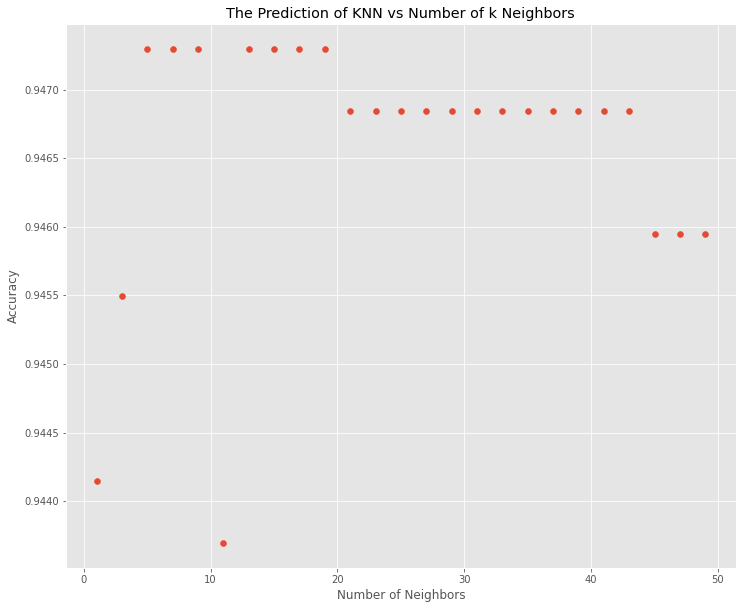

In [14]:
nearest_nbrs(X_train,X_test, y_train,y_test)

## Part-2
Vectorize tweets based on the text. More details and reference links can be checked on the Tasks list in the start of the notebook

In [15]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import string
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words= set(stopwords.words('english'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [16]:
flags=0;
filter_tweet=[]
for i in range(len(data.text)):
  tweet=data.text[i]
  tweet =tweet.lower()
  tweet = re.sub(r"http\S+|www\S+", '', tweet, flags==re.MULTILINE)
  tweet=  tweet.translate(str.maketrans("","", string.punctuation))
  tweet= re.sub(r'\@\w+|\#',"",tweet)
  tweet_tokens=word_tokenize(tweet)
  filtered_words = [w for w in tweet_tokens if not w.lower() in stop_words]
  filtered_words = []
  for w in tweet_tokens:
    if w not in stop_words:
      filtered_words.append(w)
  ps= PorterStemmer()
  stemmed_words = [ps.stem(w) for w in filtered_words]
                  
  lemmatizer = WordNetLemmatizer()
  lemma_words=[lemmatizer.lemmatize(w,pos='a') for w in stemmed_words]
  filter_tweet.append(lemma_words)

print(filter_tweet)



[['rt', 'edwardthardi', '7th', 'us', 'circuit', 'court', 'appeal', 'upheld', 'low', 'court', 'rule', 'block', 'indiana', 'mandat', 'forc', 'women', 'undergoâ€¦'], ['rt', 'venommovi', 'world', 'enough', 'superhero', 'watch', 'new', 'venom', 'trailer', '10518'], ['rt', 'futbolb', 'teacher', 'vs', 'student', 'match', 'amp', 'one', 'teacher', 'ðÿ˜±ðÿ˜±ðÿ˜±'], ['rt', 'mashabl', 'someon', 'offic', 'actual', 'respond', 'netflix', 'tweet', 'offic'], ['rt', 'missj0hnson', 'iâ€™m', 'starbuck', 'ask', 'soy', 'milk', 'man', 'behind', 'tri', 'make', 'fun', 'think', 'iâ€™m', 'â€œhealâ€¦'], ['rt', 'baekaeri06', 'exol', 'magic', 'trick', 'one', 'snap', 'thing', 'flash', 'screen', 'yall', 'wait', 'ðÿ˜‚ðÿ˜‚ðÿ˜‚'], ['realli', 'go', 'miss', 'girl', 'swear', 'god', 'would', 'bad', 'day', 'ever'], ['1fubar', 'amandadonnell14', 'sw18780774', 'taker', 'human', 'life', 'great', 'sin'], ['rt', 'timhiggins2287', 'year', 'wst', 'show', 'wisi', 'uw', 'system', 'make', 'univers', 'teach', 'research', 'public', 'ser

In [17]:
filter_sentence=[[' '.join(i)] for i in filter_tweet]
print(filter_sentence)

raw_list = [num for sublist in filter_sentence for num in sublist]

print(raw_list)

[['rt edwardthardi 7th us circuit court appeal upheld low court rule block indiana mandat forc women undergoâ€¦'], ['rt venommovi world enough superhero watch new venom trailer 10518'], ['rt futbolb teacher vs student match amp one teacher ðÿ˜±ðÿ˜±ðÿ˜±'], ['rt mashabl someon offic actual respond netflix tweet offic'], ['rt missj0hnson iâ€™m starbuck ask soy milk man behind tri make fun think iâ€™m â€œhealâ€¦'], ['rt baekaeri06 exol magic trick one snap thing flash screen yall wait ðÿ˜‚ðÿ˜‚ðÿ˜‚'], ['realli go miss girl swear god would bad day ever'], ['1fubar amandadonnell14 sw18780774 taker human life great sin'], ['rt timhiggins2287 year wst show wisi uw system make univers teach research public servic availableâ€¦'], ['thank benjaminstaal00 fantast photo boat â›µï¸\x8fâ ðÿ “ ·'], ['rt calijag made tipton actual hotel disney world disney land'], ['anigga gone act right girl realli wan na ðÿ ’ ¯ donâ€™t forc anigga noth'], ['rt choradiyamehul look headlin aajtak mishra alleg kejriw â‚¹

In [18]:
vectorizer=TfidfVectorizer()
vector=vectorizer.fit_transform(raw_list)
print(vector.shape)

vectorized_text=pd.DataFrame(vector.toarray(), columns=vectorizer.get_feature_names())
vectorized_text['originalText']=pd.Series(raw_list)

vectorized_text.head(5)

(11099, 27301)


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,0017,002,00injun,01,010â,012doh,02,...,ˆè,ˆê,ˆë,ˆëš,ˆì,ˆì¹œ,ˆí,ˆï¼,ˆðÿ,originalText
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rt edwardthardi 7th us circuit court appeal up...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rt venommovi world enough superhero watch new ...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rt futbolb teacher vs student match amp one te...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rt mashabl someon offic actual respond netflix...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,rt missj0hnson iâ€™m starbuck ask soy milk man...


In [19]:

from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix


X = StandardScaler(with_mean=False).fit_transform(vector)
print(X)
# representing in CSR form
X_sparse = csr_matrix(X)
print(X_sparse)

tsvd = TruncatedSVD(n_components=15)


X_sparse_tsvd = tsvd.fit(X_sparse).transform(X_sparse)
print(X_sparse_tsvd)
#tsvd.set_output()
# shape of the reduced matrix
print(type(X_sparse_tsvd))

print(X_sparse_tsvd.shape)
#print(x.shape)

  (0, 24380)	74.50167904301816
  (0, 25599)	9.13813265744712
  (0, 8837)	10.105448726465582
  (0, 14480)	56.458317175054795
  (0, 11302)	51.77925338895848
  (0, 3384)	16.08389517268585
  (0, 20001)	10.64558194765488
  (0, 14113)	16.961219293318226
  (0, 24548)	74.50167904301816
  (0, 2005)	30.075651595471477
  (0, 5630)	22.757323853776885
  (0, 4903)	58.332443134069536
  (0, 24585)	4.687035236011943
  (0, 771)	35.99148792289568
  (0, 7498)	74.50167904301816
  (0, 19967)	1.462869293577173
  (1, 68)	12.684731871075703
  (1, 23844)	10.794216372305646
  (1, 24769)	10.443223966495374
  (1, 16267)	6.571513088727213
  (1, 25172)	8.62576192829553
  (1, 22410)	12.03148558586514
  (1, 7807)	10.880463509768344
  (1, 25657)	7.069108180759749
  (1, 24770)	12.99872016907932
  :	:
  (11096, 17409)	13.526135665281593
  (11096, 21927)	11.544935481136813
  (11096, 14768)	10.934623492253374
  (11096, 9603)	7.433849353582426
  (11096, 25202)	8.311828752336753
  (11097, 16661)	105.35653795615309
  (11097, 

Perform KNN using the vector obtained from tweet_vectoriser() function. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

# **Classifier for Text**

In [20]:
# your code here

X_train, X_test, y_train, y_test = train_test_split(X_sparse_tsvd, labels, test_size=0.2)
accuracies=[]
for i in range(1, 50, 2):
  nbrs = NearestNeighbors(n_neighbors=i, algorithm='ball_tree')
  nbrs.fit(X_train)
  distances, indices = nbrs.kneighbors(X_test)
  y_pred = y_train.values[indices]
  y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
  #classifier
  prediction=stats.mode(y_pred, axis = 1).mode
  prediction=np.array(prediction)
  score = len(prediction[prediction==np.array(y_test)]) / y_test.shape[0]
  
  accuracies.append(score)


print(accuracies)


[0.9108108108108108, 0.9247747747747748, 0.9297297297297298, 0.9261261261261261, 0.9261261261261261, 0.9220720720720721, 0.9243243243243243, 0.9193693693693694, 0.9184684684684684, 0.9202702702702703, 0.9202702702702703, 0.9211711711711712, 0.9216216216216216, 0.9207207207207208, 0.9216216216216216, 0.9216216216216216, 0.922972972972973, 0.9220720720720721, 0.922972972972973, 0.9247747747747748, 0.9283783783783783, 0.9279279279279279, 0.9279279279279279, 0.9279279279279279, 0.9274774774774774]


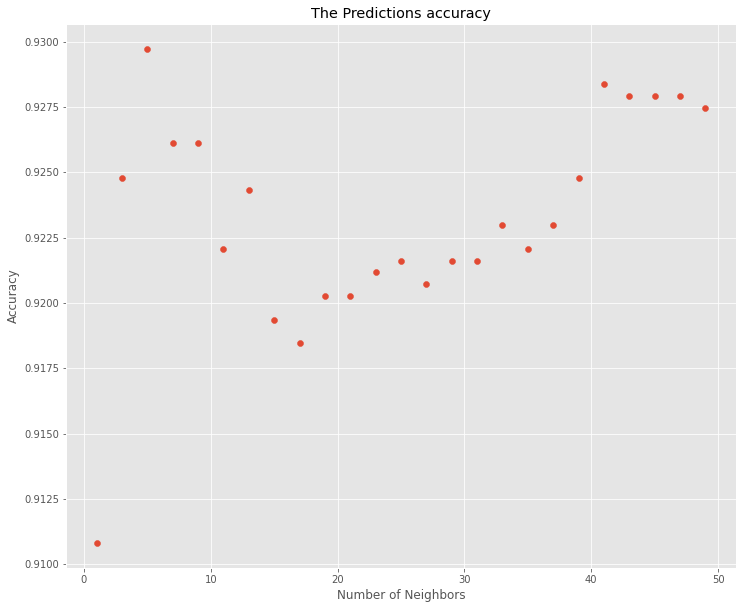

In [24]:
plt.style.use('ggplot')
plt.figure(figsize=(12,10))
plt.scatter(range(1, 50, 2), accuracies)
plt.title("The Predictions accuracy")
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")
plt.show()

## Part-3
### Subpart-1

Combine both the vectors obtained from the tweet_vectoriser() and get_features()

In [25]:
# your code here
print(type(X_sparse_tsvd))
print(type(features.to_numpy()))
print(features.shape)
combine_data= np.hstack((X_sparse_tsvd,features))
combine_data[0]


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(11099, 8)


array([-0.10548905, -0.32658896,  0.21270935, -0.14918979,  0.07233977,
        0.22707209, -0.487679  , -0.4821402 , -0.18444134,  0.55054301,
       -0.09789443,  1.36443486, -0.41040626,  1.06829823,  0.15663726,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

Perform KNN using the vector obtained in the previous step. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

# **Combined Classifier**

[-0.08621102  0.02702901 -0.017435   -0.01281168 -0.04000192  0.02729361
  0.0319886  -0.02881025 -0.02954209 -0.02014941 -0.01857392  0.00660723
  0.03671139 -0.01610474  0.02700423 -0.15257213 -0.01753439 -0.05791709
 -0.23088114 -0.34735961 -0.20390046  4.37545652 -0.39469564]
(8879, 23)
(2220, 23)
(8879, 1)
(2220, 1)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
(8879, 23)
[0.918018018018018, 0.9346846846846847, 0.9364864864864865, 0.9423423423423424, 0.9436936936936937, 0.9495495495495495, 0.9490990990990991, 0.9495495495495495, 0.9481981981981982, 0.9436936936936937, 0.9486486486486486, 0.9436936936936937, 0.9436936936936937, 0.9436936936936937, 0.9436936936936937, 0.9436936936936937, 0.9427927927927928, 0.9427927927927928, 0.9432432432432433, 0.9423423423423424, 0.9423423423423424, 0.9432432432432433, 0.9427927927927928, 0.9418918918918919, 0.9459459459459459]


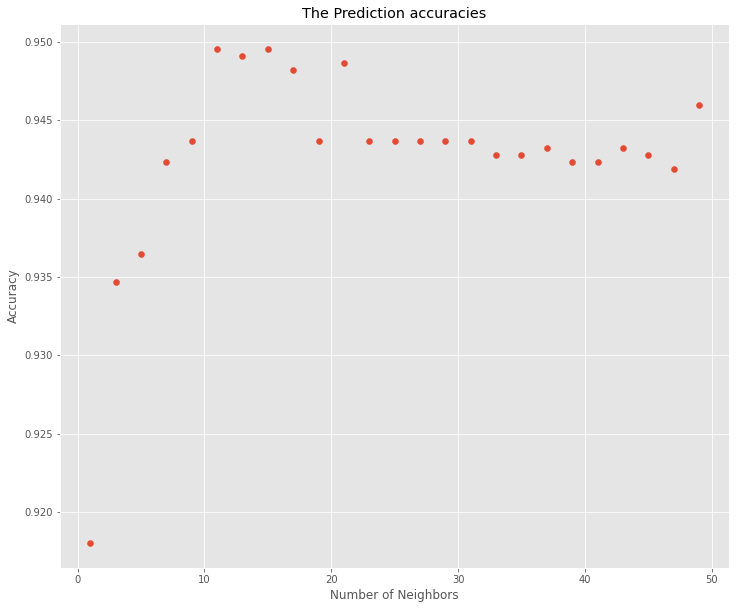

In [29]:
# your code here
scaler = StandardScaler()
scaled_features = scaler.fit_transform(combine_data)
scaled_features

#combine_data.values[:] = StandardScaler().fit_transform(combine_data)
print(scaled_features[3])
X_train, X_test, y_train, y_test= data_split(scaled_features, labels)
print(X_train.shape)
nearest_nbrs(X_train,X_test, y_train,y_test)

### Subpart-2

Explain the differences between the accuracies obtained in each part above based on the features used.

 1. The K value for the Metadata is ~3-19 with best accuracy i.e. of 94%
 2. The K value for the Texts is ~6 with best accuracy i.e. of 92%
 3. The K value for both the dataset combined is ~15 with accuracy of 94.46%.